**Install requirements**

In [ ]:
!pip install MDAnalysis pandas -q 

### **1. Execute to segregate `.gro` file into frame unit**

In [2]:
import ipywidgets as widgets
from IPython.display import display
import os

def decompose_gro_file(merged_file, output_prefix):
    with open(merged_file, 'r') as file:
        lines = file.readlines()

    frame_start_indices = [i for i, line in enumerate(lines) if line.startswith('Generated')]
    num_frames = len(frame_start_indices)

    for i in range(num_frames):
        start_index = frame_start_indices[i]
        if i < num_frames - 1:
            end_index = frame_start_indices[i + 1]
        else:
            end_index = len(lines)

        frame_lines = lines[start_index:end_index]

        # Extract the frame number from the "Generated by" line
        frame_number = i + 1
        frame_lines[0] = frame_lines[0].replace('Generated by trjconv', f'frame_{frame_number}')

        output_file = f"{output_prefix}_{frame_number}.gro"
        with open(output_file, 'w') as file:
            file.writelines(frame_lines)

# Usage example
merged_file = os.path.join(os.getcwd(), './source_trj/prod_trjconv_SOL.gro')
output_prefix = './segregated/frame'
decompose_gro_file(merged_file, output_prefix)

# echo
print("INFO: Decomposition completed. The output files are in the './segregated' directory.")

INFO: Decomposition completed. The output files are in the './segregated' directory.


### **2. Run and find $F_3$ values per frame**

$$
F_3 = <(cos\varphi_{BAC}|cos\varphi_{BAC}| + cos^2(104.52^{\circ}))^2>
$$

where $\varphi_{BAC}$ is the angle between water oxygen, A and two oxygens B and C, in its neighbor shell. The value of angle is $104.52^{\circ}$ for _TIP4P 4-site water model_. $F_3$ is equal to **0** for the ice and hydrate structures, and the average value of $F_3$ for liquid water system is about **0.1**.

In [3]:
import math
import numpy as np
import MDAnalysis as mda
import warnings
import os

def calculate_f3(universe):
    f3_values = []
    water_molecules = universe.select_atoms("resname SOL")
    oxygen_atoms = water_molecules.select_atoms("name O")
    
    # Set the reference angle (in radians) for TIP4P 4-site water model
    ref_angle = math.radians(104.52) # change value to 109.5 deg if you use SPC or SPC/E water model
    
    for frame in universe.trajectory:
        cos_phi_avg = 0
        num_triplets = 0
        
        for i in range(len(oxygen_atoms)):
            for j in range(len(oxygen_atoms)):
                if i != j:
                    for k in range(j+1, len(oxygen_atoms)):
                        if i != k:
                            o1 = oxygen_atoms[i]
                            o2 = oxygen_atoms[j]
                            o3 = oxygen_atoms[k]
                            
                            phi_bac = calculate_angle(o2, o1, o3)
                            cos_phi_bac = math.cos(phi_bac)
                            
                            term = cos_phi_bac * abs(cos_phi_bac) + math.cos(ref_angle)**2 # 
                            cos_phi_avg += term**2 
                            num_triplets += 1
        
        f3 = cos_phi_avg / num_triplets
        f3_values.append(f3)
    
    return np.array(f3_values)

def calculate_angle(atom1, atom2, atom3):
    v1 = atom1.position - atom2.position
    v2 = atom3.position - atom2.position
    
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = math.acos(cos_angle)
    
    return angle

# Suppress the warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Directory containing the frame files
frame_dir = "./segregated/"

# Output file to store the frame - F3 values
output_file = "frame_f3_values.csv"

# Get the list of frame files
frame_files = [file for file in os.listdir(frame_dir) if file.endswith(".gro")]

# Sort the frame files based on their numerical frame number
frame_files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Open the output file in write mode
with open(output_file, "w") as file:
    # Iterate over the sorted frame files
    for frame_file in frame_files:
        # Load the frame file
        universe = mda.Universe(os.path.join(frame_dir, frame_file))
        
        # Calculate the F3 order parameter for the frame
        f3_value = calculate_f3(universe)
        
        # Extract the frame number from the file name
        frame_number = frame_file.split("_")[1].split(".")[0]
        
        # Write the frame - F3 value to the output file
        file.write(f"{frame_number},{f3_value[0]}\n")
        
        # Print the frame - F3 value in the shell
        print(f"{frame_number},{f3_value[0]}")

1,0.4389346229676665
2,0.28983631108624514
3,0.3388557641759112
4,0.30041182383830684
5,0.32874678710502075
6,0.37484584539364757
7,0.3465822660775157
8,0.36003490845337816
9,0.2967800224512795
10,0.28225425539533316
11,0.2796114788520968
12,0.2940629105271549
13,0.2688242786789342
14,0.32168424111124305
15,0.3298336494223756
16,0.33654249974307643
17,0.32978100100419355
18,0.3489360231526385
19,0.3317480671086089
20,0.35687313883657173
21,0.35387605387648396
22,0.39896497011948173
23,0.4200960816330962
24,0.4187222226433033
25,0.3911914688429216
26,0.37593675693096684
27,0.34082167089324306
28,0.3073162553977593
29,0.299530065564621
30,0.34412257327621276
31,0.29429594931067443
32,0.30549536219034334
33,0.31007430886723775
34,0.29845262199408107
35,0.314462100954896
36,0.29077630105246227
37,0.31222116770549857
38,0.3363707014925657
39,0.3421656246198249
40,0.37248260593428634
41,0.3600939683382121
42,0.3480064835891913
43,0.3316625078011192
44,0.33347371863687236
45,0.382926950620770

### **3. Plot $F_3$ - frame graph**

##### **3-1. Raw only**

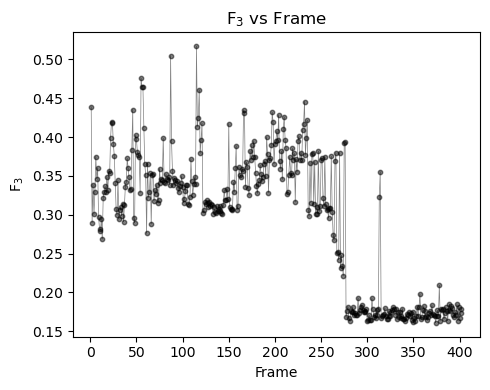

In [9]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('./frame_f3_values.csv', header=None, names=['frame', 'f3'])

# Plot 
fig = plt.figure(figsize = (5, 4))
plt.scatter(df['frame'], df['f3'], s=10, c='k', alpha=0.5)
plt.plot(df['frame'], df['f3'], c='k', alpha=0.5, lw=0.5)

plt.xlabel('Frame')
plt.ylabel(r'F$_3$')
plt.title(r'F$_3$ vs Frame')
plt.tight_layout() 
plt.savefig('f3_vs_frame_raw.png', dpi = 400, bbox_inches = 'tight')

##### **3-2. With raw and moving avg.**

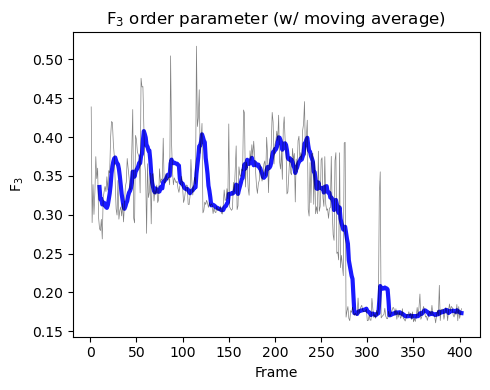

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

# moving average 
rolling_value = 10 

# read data
df = pd.read_csv('./frame_f3_values.csv', header=None, names=['frame', 'f3'])

# Calculate moving average
df['f3_rolling'] = df['f3'].rolling(rolling_value).mean()

# Plot both raw and dmoving average 

## moving avg
fig = plt.figure(figsize = (5, 4))
plt.plot(df['frame'], df['f3_rolling'], c='b', alpha=0.9, lw=3)

## original
plt.plot(df['frame'], df['f3'], c='k', alpha=0.5, lw=0.5)

## labeling
plt.xlabel('Frame')
plt.ylabel(r'F$_3$')
plt.title(r'F$_3$ order parameter (w/ moving average)')

plt.tight_layout()

plt.savefig('f3_vs_frame_rolling.png', dpi = 400, bbox_inches = 'tight')